# Perceptron

* Give biological introduction, provide two images - one biological, one artificial
* Explain how the algorithm works mathematically
* Maybe give an animation of how the discriminative line moves
* They can be trained to implement an AND gate

1. Initialize the weights
2. For each training sample $\mathbf{x}^{(i)}$
    3. Compute $\hat{y}^{(i)} = \phi (\mathbf{w}^T \mathbf{x}^{(i)})$
    4. Compute $\mathbf{w} := \mathbf{w} + \eta(y^{(i)} - \hat{y}^{(i)}) \mathbf{x}^{(i)}$

Alternatively, we could do the update using batch gradient descent, where, rather then shifting the hyperplane, we use RMSE, $\phi (z) = z$ is an identity and step 4. would look like this:
$w_i := w_i - \sum_j \eta(y^{(j)} - \hat{y}^{(j)}) x_i^{(j)} \rightarrow \Delta \mathbf{w} = \eta (\mathbf{y} - \hat{\mathbf{y}})^T\mathbf{X}^T$

* In the case that $y^{(i)} = \hat{y}^{(i)}$ the weights remain unchanged
* In the case that $y^{(i)} \neq \hat{y}^{(i)}$ the weights are moved in the direction of $\mathbf{x}^{(i)}$. This is because if $\hat{y}^{(i)}$ is negative and it should be positive, i.e. $z$ is too small, we  $2\eta \mathbf{x}^{(i)}$, i.e. the vectors w and x are too orthogonal, so we should move in the direciton of the other (but we can't move x). Adding multiple of the vector ensures that. The other case is analogous, but instead we subtract it  (move it away).
* The classes must be linearly separable.

In [33]:
import numpy as np
from abc import abstractmethod

class Perceptron:
    
    def __init__(self, num_iters=100, learning_rate=1, epsilon=0.01, init_mean=0.0, init_std=0.01, random_state=0):
        self.num_iters = num_iters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.init_mean = init_mean
        self.init_std = init_std
        self.random_state = random_state
        
    def _init_weights(self, X):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=self.init_mean, scale=self.init_std, size=X.shape[1]+1)
        
    def _predict(self, x):
        return self._activation_function(x @ self.w_[1:] + self.w_[0])
    
    def _plot_dec_boundary(self):
        pass
    
    @abstractmethod
    def fit(self, X, Y):
        pass
                 
    @abstractmethod
    def _activation_function(self, z):
        pass
    
        
    @abstractmethod
    def _update_weights(self, y_hat, x, y):
        pass


class PerceptronDelta(Perceptron):
    
    def fit(self, X, y):
        self.loss_history_ = []
        
        self._init_weights(X)
        
        for _ in range(self.num_iters):
            num_errors = 0
            for x_i, y_i in zip(X, y):
                y_i_hat = self._predict(x_i)
                num_errors += 1 if y_i_hat != y_i else 0
                self._update_weights(y_i_hat, x_i, y_i)
            loss = self._record_loss(num_errors, X)
            if loss < self.epsilon:
                break
        return self
                
    def _activation_function(self, z):
        return 1 if z >= 0 else -1

    def _update_weights(self, y_hat, x, y):
        update = self.learning_rate * (y-y_hat)
        self.w_[1:] += update*x
        self.w_[0] += update 
    
    def _record_loss(self, num_errors, X):
        loss = num_errors / len(X)
        self.loss_history_.append(loss)
        return loss
        
    
class PerceptronBGD(Perceptron):
    
    def fit(self, X, y):
        self.loss_history_ = []
        
        self._init_weights(X)
        for _ in range(self.num_iters):
            y_hats = self._predict(X)
            errors = y - y_hats
            self._update_weights(errors, X)
            self._record_loss(errors)
        return self
            
    def _update_weights(self, errors, X):
        self.w_[1:] += self.learning_rate * X.T @ errors
        self.w_[0:] += self.learning_rate * np.sum(errors)
        
    def _record_loss(self, errors):
        loss = 0.5 * np.sum(errors**2)
        self.loss_history_.append(loss)
        
    def _activation_function(self, z):
        return z
    
    
class PerceptronSGD(Perceptron):
    
    def partial_fit(self, X, y):
        pass
    
    def _activation_function(self, z):
        return z
    
class PerceptronMBGD(Perceptron):
    
    def partial_fit(self, X, y):
        pass
    
    def _activation_function(self, z):
        return z

In [34]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.sort_values(by=4)
print('Unique classes: {}'.format(', '.join(df[4].unique())))

Unique classes: Iris-setosa, Iris-versicolor, Iris-virginica


In [35]:
train_size = 100
test_size = 50
X_train, y_train = df.iloc[:train_size, :-1].values, df.iloc[:train_size, 4].values
y_train = np.where(y_train == 'Iris-setosa', -1, 1)

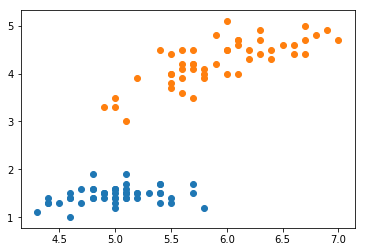

In [36]:
import matplotlib.pyplot as plt
plt.scatter(X_train[:50, 0], X_train[:50, 2])
plt.scatter(X_train[50:, 0], X_train[50:, 2])
plt.show()

/home/miroslav/.local/lib/python3.5/site-packages/ipykernel_launcher.py:88: RuntimeWarning: overflow encountered in square


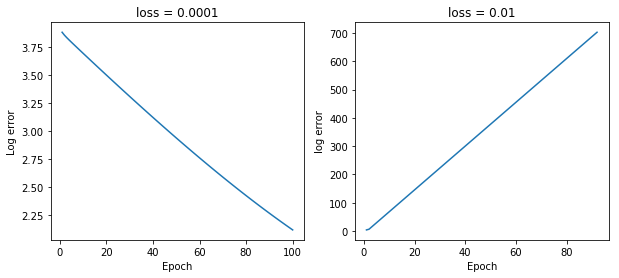

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
perc_bgd1 = PerceptronBGD(num_iters=100, learning_rate=0.0001)
perc_bgd2 = PerceptronBGD(num_iters=100, learning_rate=0.01)
perc_bgd1.fit(X_train[:, (0,2)], y_train)
perc_bgd2.fit(X_train[:, (0,2)], y_train)

ax[0].plot(range(1, len(perc_bgd1.loss_history_)+1), np.log(perc_bgd1.loss_history_))
ax[0].set_title('loss = 0.0001')
ax[0].set_ylabel('Log error')
ax[0].set_xlabel('Epoch')
ax[1].plot(range(1, len(perc_bgd2.loss_history_)+1), np.log(perc_bgd2.loss_history_))
ax[1].set_title('loss = 0.01')
ax[1].set_ylabel('log error')
ax[1].set_xlabel('Epoch')
plt.show()

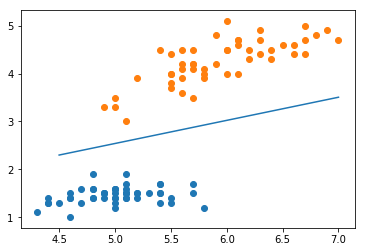

In [38]:
x = np.linspace(4.5, 7, 100)
y = (-x*perc_bgd1.w_[1] - perc_bgd1.w_[0]) / perc_bgd1.w_[2]
plt.scatter(X_train[:50, 0], X_train[:50, 2])
plt.scatter(X_train[50:, 0], X_train[50:, 2])
plt.plot(x, y)
plt.show()